<a href="https://colab.research.google.com/github/Hinakoushar-Tatakoti/Hand-written-Math-sysmbol-recognization/blob/master/Hnadwritten_Math_Symobol_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

In [ ]:
!kaggle datasets download -d xainano/handwrittenmathsymbols

handwrittenmathsymbols.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
##!unzip  handwrittenmathsymbols.zip

In [ ]:
!unrar x data.rar "/content/data/"

# Start Building the project code

In [ ]:
!pwd
!pip install split-folders
!pip install split-folders tqdm

/content


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras import backend as K
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import EarlyStopping

##from ipynb.fs.full.model import *
import os
import pickle

import os
import numpy as np
from tqdm import tqdm
from fastai import *
import torch

%matplotlib inline

import cv2
import pandas as pd
import splitfolders
import random

In [4]:
data = os.listdir("/content/data/extracted_images/")
len(data)

82

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True    

SEED = 999
seed_everything(SEED)

In [6]:
# Infos about our Dataset
nbr_of_pictures = []

labels = os.listdir("/content/data/extracted_images")
for _, _, files in os.walk(r'/content/data/extracted_images'):
    nbr_of_pictures.append(len(files))

nbr_of_pictures=nbr_of_pictures[1:]
#print nbr of pictures in every class
print("Number of samples in every class ...")
for i in range(82):  # 82 : Nbr of classes
    print(labels[i]," : ",nbr_of_pictures[i])

Number of samples in every class ...
f  :  3712
)  :  14355
T  :  3274
2  :  26141
mu  :  177
X  :  26594
prime  :  329
p  :  2680
q  :  1230
N  :  10862
pi  :  2332
gt  :  258
1  :  26520
+  :  25112
}  :  377
forward_slash  :  199
z  :  5870
u  :  1269
i  :  5140
3  :  10909
-  :  33997
exists  :  21
rightarrow  :  1703
R  :  2671
ldots  :  609
]  :  780
geq  :  693
tan  :  2450
Delta  :  137
gamma  :  409
7  :  2909
[  :  778
sum  :  2689
leq  :  973
C  :  5802
d  :  4852
sqrt  :  8908
H  :  1464
lambda  :  109
sigma  :  201
v  :  1558
int  :  2742
G  :  1692
w  :  556
o  :  449
times  :  3251
alpha  :  2546
phi  :  355
l  :  1017
0  :  6914
div  :  868
A  :  12367
S  :  1413
cos  :  2986
,  :  1906
neq  :  558
infty  :  1783
(  :  14294
pm  :  802
theta  :  2796
e  :  3003
log  :  2001
lt  :  477
in  :  47
k  :  3074
lim  :  1675
5  :  3545
M  :  2476
9  :  3737
4  :  7396
j  :  1536
6  :  3118
beta  :  2025
sin  :  4293
ascii_124  :  1339
8  :  3068
=  :  13104
y  :  9340
forall  

In [7]:
## split the data into train and val
## one time done
splitfolders.ratio('/content/data/extracted_images', output="/content/data/split", seed=SEED, ratio=(.7, .3)) 

Copying files: 375974 files [03:30, 1787.23 files/s]


In [8]:
#Initialize parametres

EPOCHS = 25
BS = 100 #Batch size
LR = 1e-3 #Learning rate 0.001
img_dim = (45,45,3)
train_data_dir = '/content/data/split/train'
test_data_dir = '/content/data/split/val'
#labels = []
#Nbr of training images
train_samples_nbr  = sum(len(files) for _, _, files in os.walk(r'/content/data/split/train'))
print(f"Number of train images are {train_samples_nbr}")
#Nbr of testing images
test_samples_nbr  = sum(len(files) for _, _, files in os.walk(r'/content/data/split/val'))
print(f"Number of test images are {test_samples_nbr}")

Number of train images are 263143
Number of test images are 112831


In [9]:
if K.image_data_format() == 'channels_first':
    input_shape = (img_dim[2], img_dim[0], img_dim[1])
else:
    input_shape = (img_dim[0], img_dim[1], img_dim[2])
print(input_shape)

(45, 45, 3)


In [10]:
print(len(labels)," Classes : ",labels)
labels = np.array(labels)
print(labels)

82  Classes :  ['f', ')', 'T', '2', 'mu', 'X', 'prime', 'p', 'q', 'N', 'pi', 'gt', '1', '+', '}', 'forward_slash', 'z', 'u', 'i', '3', '-', 'exists', 'rightarrow', 'R', 'ldots', ']', 'geq', 'tan', 'Delta', 'gamma', '7', '[', 'sum', 'leq', 'C', 'd', 'sqrt', 'H', 'lambda', 'sigma', 'v', 'int', 'G', 'w', 'o', 'times', 'alpha', 'phi', 'l', '0', 'div', 'A', 'S', 'cos', ',', 'neq', 'infty', '(', 'pm', 'theta', 'e', 'log', 'lt', 'in', 'k', 'lim', '5', 'M', '9', '4', 'j', '6', 'beta', 'sin', 'ascii_124', '8', '=', 'y', 'forall', '{', '!', 'b']
['f' ')' 'T' '2' 'mu' 'X' 'prime' 'p' 'q' 'N' 'pi' 'gt' '1' '+' '}'
 'forward_slash' 'z' 'u' 'i' '3' '-' 'exists' 'rightarrow' 'R' 'ldots' ']'
 'geq' 'tan' 'Delta' 'gamma' '7' '[' 'sum' 'leq' 'C' 'd' 'sqrt' 'H'
 'lambda' 'sigma' 'v' 'int' 'G' 'w' 'o' 'times' 'alpha' 'phi' 'l' '0'
 'div' 'A' 'S' 'cos' ',' 'neq' 'infty' '(' 'pm' 'theta' 'e' 'log' 'lt'
 'in' 'k' 'lim' '5' 'M' '9' '4' 'j' '6' 'beta' 'sin' 'ascii_124' '8' '='
 'y' 'forall' '{' '!' 'b']


In [11]:
#earlyStopping = EarlyStopping(monitor="val_loss", mode="min", patience=2)
earlyStopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

In [12]:
print("[INFO] class labels:")
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)
print(labels)

[INFO] class labels:
[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# Add a model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from keras import backend as K

In [14]:
class myModel:
    @staticmethod
    def build(width, height, depth, classes, activFct="softmax"): 
        #finalAct='softmax' for single-label classification || finalAct='sigmoid' for multi-label classification 
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
 
        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
        # CONV => RELU => POOL
        model.add(Conv2D(32, (2, 2), input_shape = inputShape)) 
        model.add(Activation('relu')) 
        model.add(MaxPooling2D(pool_size =(2, 2))) 
        
        model.add(Conv2D(32, (2, 2))) 
        model.add(Activation('relu')) 
        model.add(MaxPooling2D(pool_size =(2, 2))) 
        
        model.add(Conv2D(64, (2, 2))) 
        model.add(Activation('relu')) 
        model.add(MaxPooling2D(pool_size =(2, 2))) 
        
        model.add(Flatten()) 
        model.add(Dense(64)) 
        model.add(Activation('relu')) 
        model.add(Dropout(0.5)) 
        model.add(Dense(classes)) 
        model.add(Activation(activFct))

 
        # return the constructed network architecture
        return model

In [15]:
# Building the model 
model = myModel.build(
    width=img_dim[1], height=img_dim[0],
    depth=img_dim[2], classes=82,activFct="softmax") #for multi-class classification
model.summary()
print('Number of layers of our model : ',len(model.layers))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 44, 32)        416       
                                                                 
 activation (Activation)     (None, 44, 44, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 32)        4128      
                                                                 
 activation_1 (Activation)   (None, 21, 21, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 32)       0         
 2D)                                                    

Adding another model

In [16]:
opt = Adam(learning_rate=LR, decay=LR / EPOCHS)

In [17]:
# Compiling the model 
#import tensorflow.python.keras.optimizer_v2.adam.Adam
#opt = RMSprop(lr=LR, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy']) 

In [18]:
# data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.0,
    zoom_range=0.0,
    featurewise_center=False,# set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0.0,  # randomly rotate images in the range (deg 0 to 180)
    width_shift_range=0.0,  # randomly shift images horizontally
    height_shift_range=0.0,  # randomly shift images vertically
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False
    )

# data augmentation for testing
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [19]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_dim[0], img_dim[1]),
    batch_size=BS,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_dim[0], img_dim[1]),
    batch_size=BS,
    class_mode='categorical')

Found 263143 images belonging to 82 classes.
Found 112831 images belonging to 82 classes.


In [20]:
# Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_samples_nbr // BS,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=test_samples_nbr // BS,
    callbacks=[earlyStopping])

Epoch 1/25
2631/2631 [==============================] - 243s 88ms/step - loss: 1.7302 - accuracy: 0.5507 - val_loss: 0.7006 - val_accuracy: 0.8033
Epoch 2/25
2631/2631 [==============================] - 109s 41ms/step - loss: 1.1490 - accuracy: 0.6790 - val_loss: 0.5537 - val_accuracy: 0.8436
Epoch 3/25
2631/2631 [==============================] - 114s 43ms/step - loss: 0.9988 - accuracy: 0.7174 - val_loss: 0.4896 - val_accuracy: 0.8584
Epoch 4/25
2631/2631 [==============================] - 101s 38ms/step - loss: 0.9170 - accuracy: 0.7386 - val_loss: 0.4419 - val_accuracy: 0.8727
Epoch 5/25
2631/2631 [==============================] - 99s 38ms/step - loss: 0.8589 - accuracy: 0.7528 - val_loss: 0.4306 - val_accuracy: 0.8750
Epoch 6/25
2631/2631 [==============================] - 99s 37ms/step - loss: 0.8128 - accuracy: 0.7645 - val_loss: 0.3991 - val_accuracy: 0.8822
Epoch 7/25
2631/2631 [==============================] - 114s 43ms/step - loss: 0.7814 - accuracy: 0.7728 - val_loss: 0.3

# Saving a model

In [21]:
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True);
# save the model to disk
print("[INFO] serializing network...")
#model.save(args["model"])
model.save("model.model")
model.save_weights("weights.h5")
#save the multi-label binarizer to disk
print("[INFO] serializing label binarizer...")
# f = open(args["labelbin"], "wb")
f = open("labels.pickle", "wb")
f.write(pickle.dumps(mlb))
f.close()


[INFO] serializing network...
INFO:tensorflow:Assets written to: model.model/assets
[INFO] serializing label binarizer...


In [22]:
#probabilities = model.predict_generator(validation_generator,2000)

# Evaluating the model / Get Validation accuracy on sample from validation set
scores = model.evaluate(validation_generator,verbose=1) 
print("Accuracy = ", scores[1])


1129/1129 [==============================] - 44s 39ms/step - loss: 0.2837 - accuracy: 0.9153
Accuracy =  0.9152804017066956


In [23]:
import matplotlib.pyplot as plt

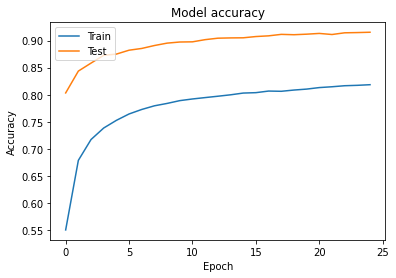

In [24]:


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model_accuary_plot.png')
plt.show()

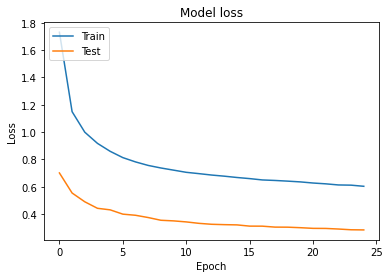

In [25]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model_loss_plot.png')
plt.show()

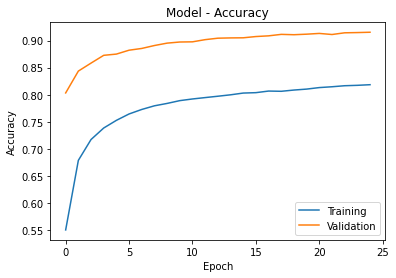

In [26]:
# Train - Val plot
fig1, ax_acc = plt.subplots()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model - Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.savefig("train_val_plot.png")

# Evaluation step

In [32]:
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os

In [33]:
# load the image
image = cv2.imread("/content/data/extracted_images/!/!_100077.jpg")
print(image.shape)
output = imutils.resize(image, width=400)
 
# pre-process the image for classification
image = cv2.resize(image, (45, 45))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

(45, 45, 3)


In [34]:
# load the trained convolutional neural network and the multi-label
# binarizer
print("[INFO] loading network...")
model = load_model("model.model")
mlb = pickle.loads(open("labels.pickle", "rb").read())
 
 #%%
# classify the input image then find the indexes of the two class
# labels with the *largest* probability
print("[INFO] classifying image...")
proba = model.predict(image)[0]
idxs = np.argsort(proba)[::-1][:2]
# loop over the indexes of the high confidence class labels

[INFO] loading network...
[INFO] classifying image...


In [35]:
for (i, j) in enumerate(idxs):
    # build the label and draw the label on the image
    label = "{}: {:.2f}%".format(mlb.classes_[j], proba[j] * 100)
    cv2.putText(output, label, (10, (i * 30) + 25), 
        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

In [36]:
# show the probabilities for each of the individual labels
for (label, p) in zip(mlb.classes_, proba):
    print("{}: {:.2f}%".format(label, p * 100))
# show the output image
#cv2.imshow("Output", output)
cv2.waitKey(0)

print ("This Symbol is :",' '.join(mlb.classes_[proba.argmax(axis=-1)]))
#model.predict_classes(image)
#result = "This Symbol is : ".join(mlb.classes_[proba.argmax(axis=-1)])

!: 99.99%
(: 0.00%
): 0.00%
+: 0.00%
,: 0.01%
-: 0.00%
0: 0.00%
1: 0.00%
2: 0.00%
3: 0.00%
4: 0.00%
5: 0.00%
6: 0.00%
7: 0.00%
8: 0.00%
9: 0.00%
=: 0.00%
A: 0.00%
C: 0.00%
D: 0.00%
G: 0.00%
H: 0.00%
M: 0.00%
N: 0.00%
R: 0.00%
S: 0.00%
T: 0.00%
X: 0.00%
[: 0.00%
]: 0.00%
_: 0.00%
a: 0.00%
b: 0.00%
c: 0.00%
d: 0.00%
e: 0.00%
f: 0.00%
g: 0.00%
h: 0.00%
i: 0.00%
j: 0.00%
k: 0.00%
l: 0.00%
m: 0.00%
n: 0.00%
o: 0.00%
p: 0.00%
q: 0.00%
r: 0.00%
s: 0.00%
t: 0.00%
u: 0.00%
v: 0.00%
w: 0.00%
x: 0.00%
y: 0.00%
z: 0.00%
{: 0.00%
}: 0.00%
This Symbol is : !
